# Milestone 2

## Intro
The main goal of our project is to find what characteristics the different news sources look for in speakers, depending on the subject of discussion. To answer this question, we are going to work with three different datasets. Indeed, we will base our analyse on The Quotebank dataset that contains quotes of speakers from 2015 to 2020. The BBC dataset will help us to train a method to regroup the quotes according to the main topics. Finally, using the Wikidataset, we aim to categorize the speakers thanks to their age, gender and nationality. 
With all those informations, we will be able to perform a number of analysis to study the evolution across different news sources of the most represented speaker in the press.

## Dataset exploration
A primary work consists of performing initial analyses and cleaning of the three datasets.

In [1]:
import pandas as pd
import numpy as np
import bz2
import tqdm as tqdm 
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

### 1. WikiDataset
The Wikidataset will be used to find the age, gender and nationality of the speakers.


The first aim is to explore the content of this dataset. We remove all the missing values, and we keep only the columns that we are interested in, that is : date of birth, nationality, gender and Id number of the speaker.

In [2]:
# Access to wikipedia data from broswer: https://www.wikidata.org/wiki/QXXX
pq = pd.read_parquet("speaker_attributes.parquet/part-00000-0d587965-3d8f-41ce-9771-5b8c9024dce9-c000.snappy.parquet")
pq.head(2)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None


In [3]:
#helper function that removes all lines with NaN value
def remove_nan(df): 
    mask = df.isnull()
    mask = mask.any(axis=1)
    nb_nan = mask.sum()
    return df[~mask.values].reset_index(drop=True), nb_nan


path = "speaker_attributes.json.bz2" #path where save the metadata
nb = ['0000','0001','0002','0003','0004','0005','0006','0007','0008',
      '0009','0010','0011','0012','0013','0014','0015']

#Choose which column we keep from parquet 
col = ['date_of_birth', 'nationality', 'gender','id']
TOT_nb_nan = 0
TOT_size = 0
with bz2.open(path, 'wb') as file:
    for i in tqdm.tqdm(range(len(nb))):
        parquet = pd.read_parquet("speaker_attributes.parquet/part-0"+nb[i]+"-0d587965-3d8f-41ce-9771-5b8c9024dce9-c000.snappy.parquet")
        TOT_size += parquet.shape[0]
        parquet_buff = parquet[col].copy()
        parquet_buff,nb_nan = remove_nan(parquet_buff)
        TOT_nb_nan += nb_nan
        file.write(parquet_buff.to_json(compression='bz2',lines=True, orient='records').encode('utf-8'))

print(f'We remove {TOT_nb_nan} over a total of {TOT_size}.')

100%|██████████| 16/16 [01:14<00:00,  4.69s/it]

We remove 6011526 over a total of 9055981.


In [4]:
#Display filtered Wikidataset 
parquet = pd.read_json('speaker_attributes.json.bz2',lines=True, orient='records', compression='bz2') 
print(f'Shape of filtered parquets:{parquet.shape}')
parquet.head(2)

Shape of filtered parquets:(3044455, 4)


,date_of_birth,nationality,gender,id
0,[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],Q23
1,[+1952-03-11T00:00:00Z],[Q145],[Q6581097],Q42


To find the age of the speaker, we make the decision to clean the data by keeping only the year of birth. Moreover, some speakers happen to have more than one attribute. In that case, we choose  to keep only one attribute per column.

In [5]:
pq_buffer = parquet.copy()
#if there are more than one value in a fild we make the arbitrary decision to choose only one
pq_buffer['nationality'] = pq_buffer['nationality'].apply(lambda x: x[0])
pq_buffer['gender'] = pq_buffer['gender'].apply(lambda x: x[0])

pq_buffer['date_of_birth'] = pq_buffer['date_of_birth'].apply(lambda x: x[0][1:5]) #save only year 
pq_buffer.head(2)

,date_of_birth,nationality,gender,id
0,1732,Q161885,Q6581097,Q23
1,1952,Q145,Q6581097,Q42


Each gender and nationality is characterized by a QID number. We process our dataset to associate the QID number to the written value it corresponds to. To do so, we use the the Wikidata labels description quote bank file that links every nationality and gender QID number.

In [6]:
#load data for label description 
label =  pd.read_csv('wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2') 
label.head(2)

,QID,Label,Description
0,Q31,Belgium,country in western Europe
1,Q45,Portugal,country in southwestern Europe


In [7]:
#Generate dict for replace qids with label
mask1 = label['QID'].isin(set(pq_buffer.nationality))
dict_nat = dict(zip(label.QID[mask1],label.Label[mask1]))
mask2 = label['QID'].isin(set(pq_buffer.gender))
dict_gen = dict(zip(label.QID[mask2],label.Label[mask2]))

#replace qid
pq_buffer = pq_buffer.replace(dict_nat)
pq_buffer = pq_buffer.replace(dict_gen)
pq_buffer.head(2)

,date_of_birth,nationality,gender,id
0,1732,Great Britain,male,Q23
1,1952,United Kingdom,male,Q42


In [8]:
#save the clean and processed wikidataset 
path = "speaker_attributes_final.json.bz2"
with bz2.open("speaker_attributes_final.json.bz2", 'wb') as d_file:
    d_file.write(pq_buffer.to_json(compression='bz2',lines=True, orient='records').encode('utf-8'))

Each speaker’s gender, age and nationality can now be found according to their Id number. We can proceed to work on the Quotebank dataset.

### 2. QuoteBank dataset

We will load and process the Quotebank dataset. This dataset contains quotes from different speakers from different news sources  (for each year from 2015 to 2020).

The Quotebank dataset is filtered by dropping all the lines containing missing values with respect to the speaker. As we will analyze our datas across different news sources, we convert the urls in site names. In order to be able to generate plots for further analysis, we choose to round the date of the quotes. Indeed, our analysis will be based on big timescale (day or years), so we remove the minutes and seconds. We use the WikiData  previously cleaned and processed to avoid mistakes in futur analyses : we drop all the quotes that are not surely associated with a speaker, as well as the lines containing speakers that do not match with a Wikidata Id. 

We also choose to get rid of unnecessary characters and stop words in the quotations. The purpose of this cleaning is to be able to perform easier word analysis when applying our Machine Learning method to generate groups of quotes by main topics.

In [9]:
#load speaker_attributes
path = "speaker_attributes_final.json.bz2"
speaker_atr = pd.read_json(path, lines=True, compression='bz2')

In [10]:
#helper function to clean the quote
def process_text(text):
    #removing some characters
    text = text.lower().replace('\n',' ').replace('\r','').strip()
    text = re.sub(' +', ' ', text)
    text = re.sub(r'[^\w\s]','',text)
    
    #removing stopwords that will not contribute to the classification
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(text) 

    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w) 
    
    text = " ".join(filtered_sentence)
    return text

'''
Helper function that clean a chunck dataframe and save only the data
of interest: 'quotation', 'speaker', 'qids', 'date', 'urls' -> 'site'.
'''
def clean_chunk(chunk):        
        #Check and remove the NaN value 
        chunk.replace('None', np.nan, inplace=True) # We need to convert the string None to a proper one.
        chunk, nb_nan = remove_nan(chunk)
                
        #convert the urls in site
        chunk['urls'] = [line[0].split('/')[2].replace('www.','') for line in chunk['urls']]
        
        #we round the timestamp to day
        chunk['date'] = chunk['date'].round('D')
        
        #drop the line where we are not sure who is the speaker (multiple pepole with the same name)
        nb_mult_name = chunk.shape[0] 
        len_quis = chunk.qids.apply(len)
        chunk = chunk[len_quis == 1]
        nb_mult_name = nb_mult_name - chunk.shape[0] #how many element we drop
        chunk['qids'] = chunk['qids'].apply(lambda x: x[0])
        
        #drop the line where the speaker doesn't have a wikidata
        nb_nonmatch = chunk.shape[0]
        chunk = chunk[chunk.qids.isin(speaker_atr.id)]
        nb_nonmatch = nb_nonmatch - chunk.shape[0] #how many element we drop
        
        #covert the quotation in proper one 
        chunk['quotation'] = chunk['quotation'].apply(process_text)
        chunk = chunk[chunk['quotation'].apply(len) > 1]
        
        return chunk.reset_index(drop=True), nb_nan, nb_mult_name, nb_nonmatch



We perform all the steps mentioned above on the Quotebank datasets from the years of 2015 to 2020. In order to visualize our filtered data we save the quotation length, the dates and the urls in a counter.

In [11]:
'''
Helper function to filter and save the dataset of a certain year, 
it returns the counters for visualisation and statitical analysis 
'''
def clean_dataset(path_dataset, path_dataset_clean):
    #Choose which column from dataset save
    col = ['quotation','speaker','date','qids', 'urls']  
    TOT_nb_nan = 0
    TOT_nb_mult_name = 0
    TOT_nb_nonmatch = 0
    TOT_size = 0
    TOT_size_clean = 0
    counter_quote, counter_date, counter_urls = Counter(),Counter(),Counter()
    with pd.read_json(path_dataset, lines=True, compression='bz2', chunksize=100000) as df_reader:
        with bz2.open(path_dataset_clean, 'wb') as d_file:
            count = 0
            for chunk in df_reader:
                print(f'({count}) Processing chunk with {chunk.shape[0]} rows', end='\r')
                TOT_size += chunk.shape[0]
                df, nb_nan, nb_mult_name, nb_nonmatch = clean_chunk(chunk[col].copy()) #remove odd values
                
                #count number odd value
                TOT_nb_nan += nb_nan
                TOT_nb_mult_name += nb_mult_name
                TOT_nb_nonmatch += nb_nonmatch
                TOT_size_clean += df.shape[0]

                #Store data for visualisation 
                counter_quote += Counter(df['quotation'].apply(len))
                counter_date += Counter(df['date'])
                counter_urls += Counter(df['urls'])
                
                #write in the ouput file
                d_file.write(df.to_json(compression='bz2',lines=True, orient='records').encode('utf-8'))
                count+=1
                
    print(f'We remove {TOT_nb_nan+ TOT_nb_mult_name + TOT_nb_nonmatch} over a total of {TOT_size}')
    print(f'No speaker {(TOT_nb_nan/TOT_size)*100} %')
    print(f'Speaker with multiple possible name {(TOT_nb_mult_name/TOT_size)*100} %')
    print(f'Speaker that do not mach the metadata {(TOT_nb_nonmatch/TOT_size)*100} %')
    print(f'The final shape of the dataset is {TOT_size_clean}')
    return counter_quote, counter_date, counter_urls



We define some helper functions to help plot the data and calculate statistic. In particular they plot the distribution for the quotes and  dates. They also print the most frequent url, and calculate min, max and mean for the quote lenght.

In [12]:
#helper function for quote: print the mean, min and max and plot the dstribution.
def describe_len_quote(counter_quote):
    quote = pd.DataFrame.from_records(counter_quote.most_common(), columns=['value','count'])
    mean = ((quote['value']*quote['count']).sum())/quote['count'].sum()
    max_ = quote['value'].max()
    min_ = quote['value'].min()
    print(f'Quote length: mean = {mean}, max = {max_}, min = {min_}')
    plt.figure(figsize=(16, 5))
    plt.bar(quote['value'], quote['count'], edgecolor="k")
    plt.title('Distribution Length Quote',fontsize=15)
    plt.show()
    
#helper function for date: plot the dstribution.  
def describe_date(counter_date):
    date = pd.DataFrame.from_records(counter_date.most_common(), columns=['value','count'])
    plt.figure(figsize=(16, 5))
    plt.bar(date['value'], date['count'], edgecolor="k")
    plt.title('Distribution Date',fontsize=15)
    plt.xticks(rotation=45)
    plt.show()
    
#helper function for urls, print most frequent
def describe_urls(counter_urls):
    urls = pd.DataFrame.from_records(counter_urls.most_common(), columns=['value','count'])
    max_ = urls['count'].max()
    val = urls['value'][urls['count'] == max_].item()
    print(f'The most frequent urls is {val} and it is present {max_} time.')
    print(f'The next 5 most frequent urls are: \n {urls[1:6]}')
    

##### Year 2020 Dataset claning and analysis 

In [13]:
#Path to dataset and the new dataset
path_dataset = 'quotes-2020.json.bz2' 
path_dataset_clean = 'quotes-2020-clean.json.bz2'
counter_quote, counter_date, counter_urls  = clean_dataset(path_dataset, path_dataset_clean)

We remove 3125918 over a total of 5244449
No speaker 34.338097291059555 %
Speaker with multiple possible name 17.765450669841577 %
Speaker that do not mach the metadata 7.500768908230397 %
The final shape of the dataset is2118203


Quote length: mean = 86.02659188000395, max = 2472, min = 2


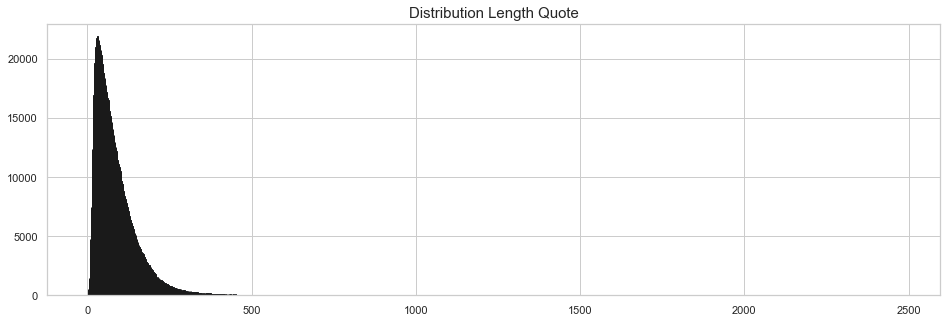

In [14]:
describe_len_quote(counter_quote)

The mean length of the quotes is quite short : around 86 characters, this result shows that the method for categorizing the quotes into groups of topics should work in an efficient way on our filtered QuoteBank dataset. 

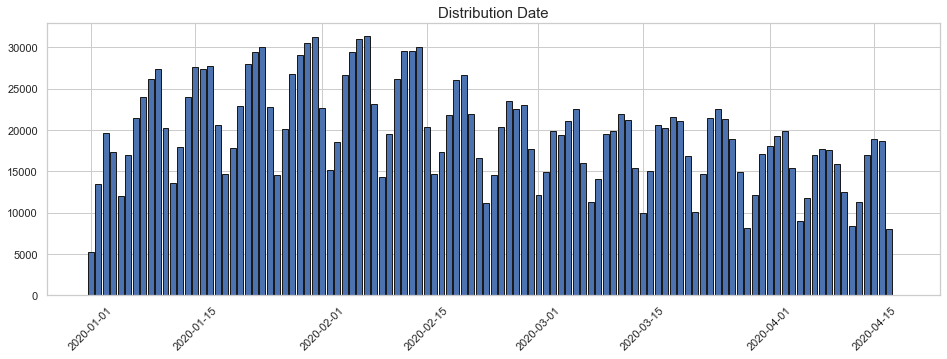

In [15]:
describe_date(counter_date)

We can assume that our dataset is well distributed over the time based on the 2020 dataset. Therefore, we will indeed be able to perform analysis over time in our futur work. On looking regulary spikes that we see we can deduct that represent the week day/weekend day.

In [16]:
describe_urls(counter_urls)

The most frequent urls is msn.com and it is present 28521 time.
The next 5 most frequent urls are: 
               value  count
1     breitbart.com  25786
2     express.co.uk  13747
3       foxnews.com  12734
4  seattletimes.com  11918
5     nbcsports.com  11889


We than perform the same analysis and cleaning for the datasets from other years.

##### Year 2019 Dataset cleaning and analysis 

In [17]:
path_dataset = 'quotes-2019.json.bz2' 
path_dataset_clean = 'quotes-2019-clean.json.bz2'
counter_quote, counter_date, counter_urls  = clean_dataset(path_dataset, path_dataset_clean)

We remove 13108699 over a total of 21763302
No speaker 34.82931036843582 %
Speaker with multiple possible name 17.96644645192168 %
Speaker that do not mach the metadata 7.437285941260201 %
The final shape of the dataset is8653437


Quote length: mean = 86.43332597209641, max = 2550, min = 2


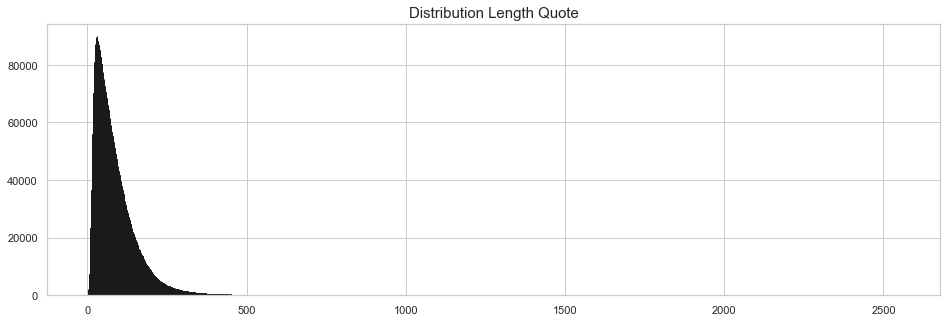

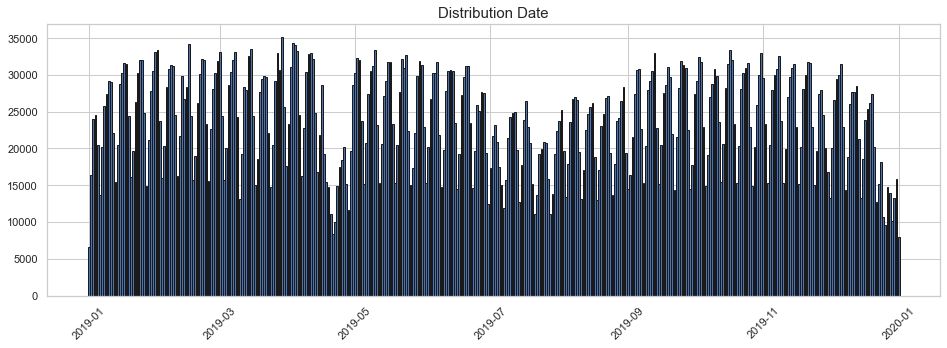

The most frequent urls is breitbart.com and it is present 106909 time.
The next 5 most frequent urls are: 
               value  count
1           msn.com  93493
2       nytimes.com  65791
3  seattletimes.com  59026
4     express.co.uk  50881
5     nbcsports.com  48038


In [18]:
describe_len_quote(counter_quote)
describe_date(counter_date)
describe_urls(counter_urls)

##### Year 2018 Dataset cleaning and analysis 

In [19]:
path_dataset = 'quotes-2018.json.bz2' 
path_dataset_clean = 'quotes-2018-clean.json.bz2'
counter_quote, counter_date, counter_urls  = clean_dataset(path_dataset, path_dataset_clean)

We remove 16650155 over a total of 27228451
No speaker 35.10310593871095 %
Speaker with multiple possible name 18.45661730812377 %
Speaker that do not mach the metadata 7.590119614222638 %
The final shape of the dataset is10576739


Quote length: mean = 84.79311127938394, max = 2636, min = 2


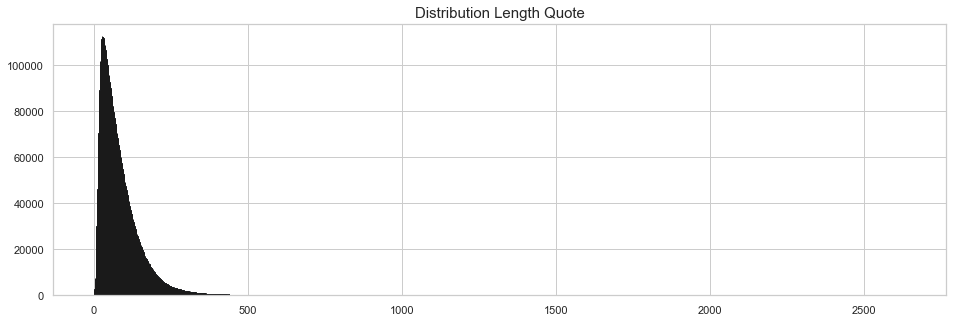

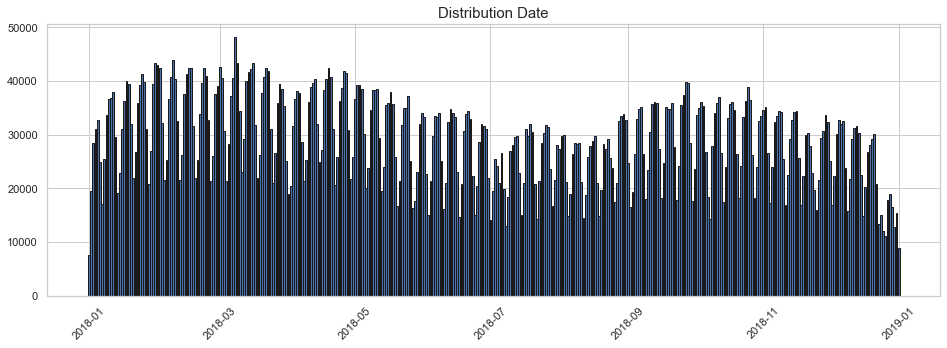

The most frequent urls is breitbart.com and it is present 82235 time.
The next 5 most frequent urls are: 
                  value  count
1              msn.com  79214
2          nytimes.com  68708
3    home.nzcity.co.nz  51460
4  washingtontimes.com  43251
5          mlb.mlb.com  40251


In [20]:
describe_len_quote(counter_quote)
describe_date(counter_date)
describe_urls(counter_urls)

##### Year 2017 Dataset cleaning and analysis 

In [21]:
path_dataset = 'quotes-2017.json.bz2' 
path_dataset_clean = 'quotes-2017-clean.json.bz2'
counter_quote, counter_date, counter_urls  = clean_dataset(path_dataset, path_dataset_clean)

We remove 16401377 over a total of 26611588
No speaker 34.86560065487261 %
Speaker with multiple possible name 19.22312565488388 %
Speaker that do not mach the metadata 7.543736209954852 %
The final shape of the dataset is10208628


Quote length: mean = 83.19875726689229, max = 2344, min = 2


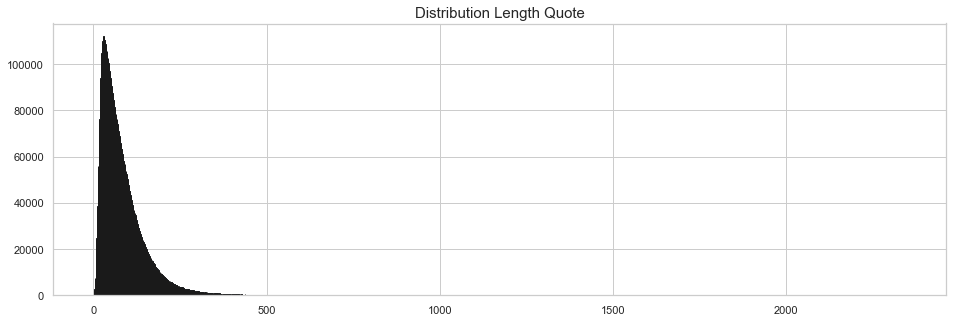

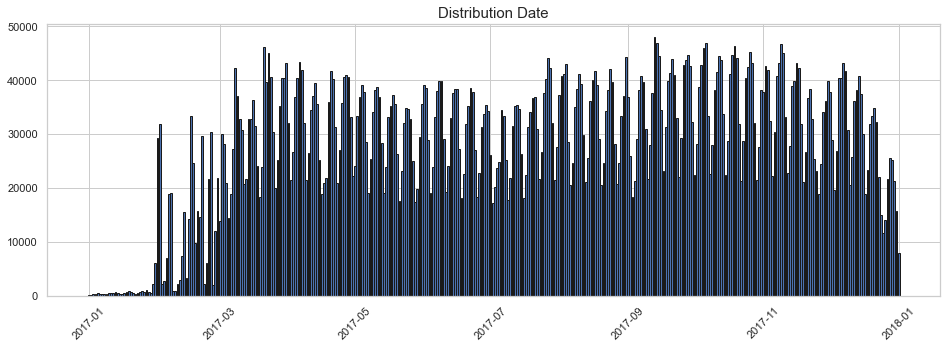

The most frequent urls is washingtonpost.com and it is present 83850 time.
The next 5 most frequent urls are: 
                value  count
1            msn.com  74646
2        nytimes.com  71355
3        mlb.mlb.com  44746
4  home.nzcity.co.nz  41730
5      breitbart.com  39773


In [22]:
describe_len_quote(counter_quote)
describe_date(counter_date)
describe_urls(counter_urls)

##### Year 2016 Dataset cleaning and analysis 

In [23]:
path_dataset = 'quotes-2016.json.bz2' 
path_dataset_clean = 'quotes-2016-clean.json.bz2'
counter_quote, counter_date, counter_urls  = clean_dataset(path_dataset, path_dataset_clean)

We remove 8512408 over a total of 13862129
No speaker 34.30508401703663 %
Speaker with multiple possible name 19.75080451206305 %
Speaker that do not mach the metadata 7.351763931788543 %
The final shape of the dataset is5348900


Quote length: mean = 81.6115160126381, max = 2231, min = 2


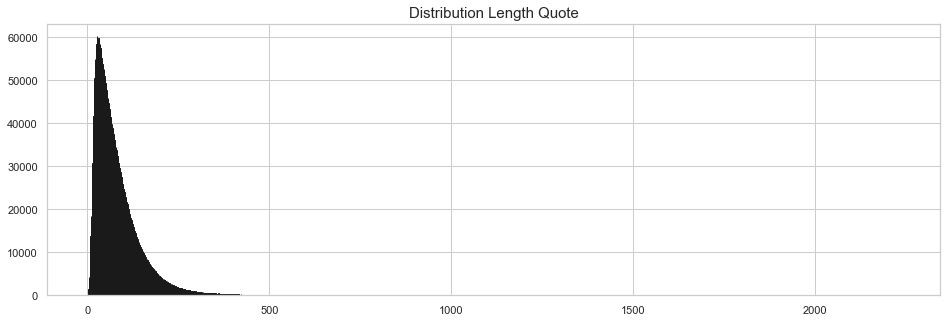

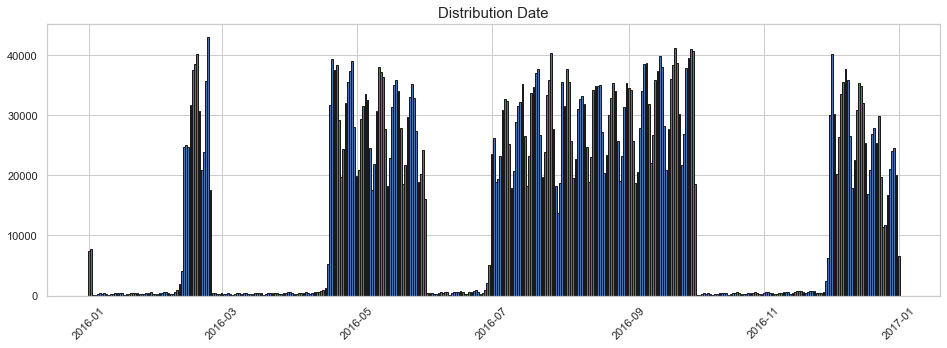

The most frequent urls is washingtonpost.com and it is present 37580 time.
The next 5 most frequent urls are: 
                 value  count
1         mlb.mlb.com  33261
2         espn.go.com  31771
3         nytimes.com  30554
4  huffingtonpost.com  28218
5             msn.com  27118


In [24]:
describe_len_quote(counter_quote)
describe_date(counter_date)
describe_urls(counter_urls)

##### Year 2015 Dataset cleaning and analysis 

In [25]:
path_dataset = 'quotes-2015.json.bz2' 
path_dataset_clean = 'quotes-2015-clean.json.bz2'
counter_quote, counter_date, counter_urls  = clean_dataset(path_dataset, path_dataset_clean)

We remove 12637271 over a total of 20874338
No speaker 33.612083889798086 %
Speaker with multiple possible name 19.807224545276597 %
Speaker that do not mach the metadata 7.120436585821309 %
The final shape of the dataset is8235740


Quote length: mean = 81.57253118724, max = 4247, min = 2


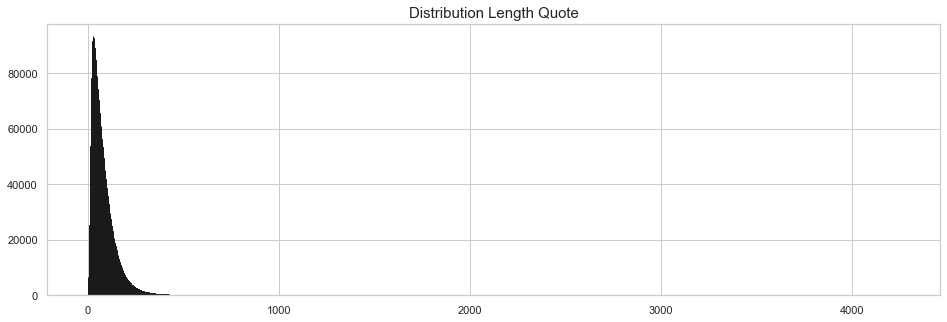

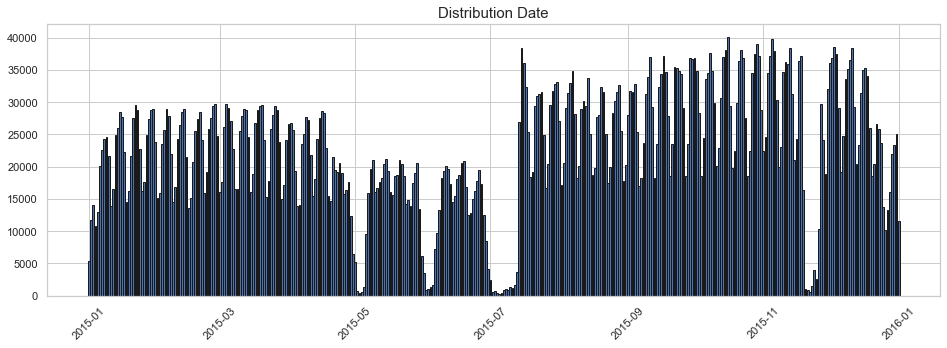

The most frequent urls is feeds.theguardian.com and it is present 95417 time.
The next 5 most frequent urls are: 
                       value  count
1               mlb.mlb.com  73094
2  feeds.washingtonpost.com  51170
3               espn.go.com  50457
4                philly.com  44191
5         au.news.yahoo.com  41525


In [26]:
describe_len_quote(counter_quote)
describe_date(counter_date)
describe_urls(counter_urls)

From the above distribution of date, we can notice that some datasets are well distributed over time (2020, 2019, 2018 and 2017) but the dataset from the years 2016 and 2015 show irregular distribution of the dates. Therefore, we will be able to perform analysis over the years without any issue. However, if we would like to analyze our data over the months, we will need to take into account the fact that some month from 2015 and 2016 has a much smaller set of quotations when we will make the deduction and interpretation of our result. 

Moreover, the mean quote length from all the years is comparable (always around 81 to 86 characters). This allows us to deduct that the method for categorizing the quotes into groups of topics computed using the BBC Dataset should work in an efficient way on our filtered QuoteBank dataset for all the years.

### 3. BBC Dataset
In this part we will preprocess the additional dataset for our project of classification of newsquotes into categories.
We will make use of the BBC news articles dataset that can be seen below. It is a datat set that contains thousands of news articles classified into five categories: *Business*, *Entertainement*, *Sports*, *Tech*, *Politics*.

The goal is to train a machine learning model capable of reading a quote and assigning it to one of these five categories. For this we will first have a look at the BBC news articles dataset and clean it. In a subsequent step we will train and test our model on this same dataset. Finally the model will be used to classify the quotes of the quotebank dataset. 

In [27]:
#importing the train set
train = './BBC_data/BBC News Train.csv'
train_data = pd.read_csv(train)

In [28]:
train_data.head(2)

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business


##### Let's look at the content
Here we will explore the content of the train data set: we will look at the present categories, the number of datapoints and we will check for missing values. 

In [29]:
#We have five distinct categories: business, tech, politics, sports, and entertainement 
train_data['Category'].unique()

array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

In [30]:
#how many data points do we have ?
#we have 1490 data points and three columns: Article id, Text and the category that the article belongs to
train_data.shape

(1490, 3)

In [31]:
#Now we check if there are missing values
train_data.isnull().any()

ArticleId    False
Text         False
Category     False
dtype: bool

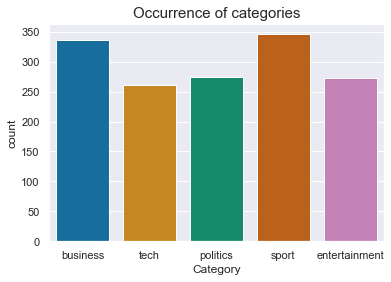

In [32]:
#Here we see how the data is balanced. We don't have a clear oversampling. 
sns.set_theme(style="darkgrid")
sns.set_palette("colorblind")
ax = sns.countplot(x="Category", data=train_data).set_title('Occurrence of categories', fontsize=15)

##### Dealing with word length
We know that this dataset contains news artices. Howvere, the quotebank dataset that we wish to classify contains quotes. The differene between the two is that news articles most likely are much longer than quotes. This means that we will probably have to truncate the news articles to match the average length of the quotes

In [33]:
#Let's look at the lentgh of the articles
train_data['Text'].str.len()

0       1866
1       2016
2       3104
3       3618
4       2190
        ... 
1485    1266
1486    3111
1487    1370
1488    3242
1489    1723
Name: Text, Length: 1490, dtype: int64

In [34]:
#we add a column to our train data set that contains the length of the quotes
train_data['len_of_article'] = train_data['Text'].str.len()
train_data['len_of_article']

0       1866
1       2016
2       3104
3       3618
4       2190
        ... 
1485    1266
1486    3111
1487    1370
1488    3242
1489    1723
Name: len_of_article, Length: 1490, dtype: int64

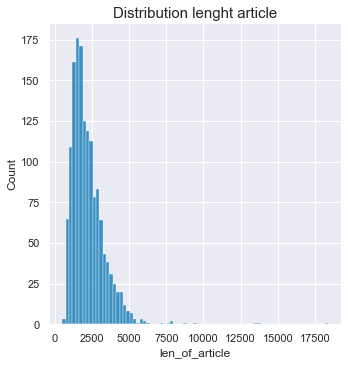

In [35]:
sns.set_theme(style="darkgrid")
sns.set_palette("colorblind")
sns.displot(data=train_data, x="len_of_article")
plt.title('Distribution lenght article', fontsize=15)
plt.show()

In [36]:
#let's print some summary statistics 
train_data['len_of_article'].describe()

count     1490.000000
mean      2233.461745
std       1205.153358
min        501.000000
25%       1453.000000
50%       1961.000000
75%       2751.250000
max      18387.000000
Name: len_of_article, dtype: float64

In [37]:
#and the median
train_data['len_of_article'].median()

1961.0

We can see in the notebook where we explored the Quotebank dataset, that these values are much higher than for the quotes we will ultimately classify. Therefore, it might be useful to truncate these articles before training our model on it. We will truncate these articles at 200 characters.


In [38]:
train_data['truncated']=train_data['Text'].str.slice(stop=200)
train_data['len_of_truncated_article'] = train_data['truncated'].str.len()


In [39]:
train_data.head(2)

,ArticleId,Text,Category,len_of_article,truncated,len_of_truncated_article
0,1833,worldcom ex-boss launches defence lawyers defe...,business,1866,worldcom ex-boss launches defence lawyers defe...,200
1,154,german business confidence slides german busin...,business,2016,german business confidence slides german busin...,200


##### Cleaning the data
Here we will do any cleaning of the data. We will remove unecessary characters and stopwords. We will only apply this cleaning to the truncated articles

In [40]:
train_data['clean_truncated'] = train_data['truncated'].apply(process_text)

In [41]:
train_data.head(2)

,ArticleId,Text,Category,len_of_article,truncated,len_of_truncated_article,clean_truncated
0,1833,worldcom ex-boss launches defence lawyers defe...,business,1866,worldcom ex-boss launches defence lawyers defe...,200,worldcom exboss launches defence lawyers defen...
1,154,german business confidence slides german busin...,business,2016,german business confidence slides german busin...,200,german business confidence slides german busin...


In [42]:
train_data.to_csv('./BBC_data/cleaned_Train.csv')

##### Preprocess the test set
The only thing we will do on the test set is to preprocess it in the same way as we did for the train dataset. That is, check for Nan values, truncate the articles and process the text in order to drop the useless charaters and words. 

In [43]:
#importing the test set
test = './BBC_data/BBC News Test.csv'
test_data = pd.read_csv(test)

In [44]:
test_data['truncated']=test_data['Text'].str.slice(stop=200)
test_data['len_of_truncated_article'] = test_data['truncated'].str.len()
test_data.head(2)

,ArticleId,Text,truncated,len_of_truncated_article
0,1018,qpr keeper day heads for preston queens park r...,qpr keeper day heads for preston queens park r...,200
1,1319,software watching while you work software that...,software watching while you work software that...,200


In [45]:
test_data['clean_truncated'] = test_data['truncated'].apply(process_text)

In [46]:
test_data.to_csv('./BBC_data/cleaned_Test.csv')

##### Next steps
Next we will have to apply the same data cleaning and truncation to the Quotebank dataset. 
In a next step we will also try different machine learning models such as random forest, logistic regression, k neighbors classifier and naive bayes classifier. We will assess their quality by applying them on the test set and then we will chose the best and apply it to the quotebank dataset.

## Future work 

### 1. Train our machine learning method to categorize quotations

We have now all the information we need to execute our project in our three datasets : 
The BBC dataset is ready to be used to find a machine learning method (random forest, logistic regression, k neighbors classifier or naive bayes classifier) that gives the best performance to categories our news quotes into categories. Each method is described below :


##### Logistic regression
In this technique, instead of modeling the response directly, we model the probability that the output falls under a certain category. Based on this probability, we then assign each element to a category. 

$\begin{split}
P(t=1| z) & = \sigma(z) = \frac{1}{1+e^{-z}} \\
P(t=0| z) & = 1 - \sigma(z) = \frac{e^{-z}}{1+e^{-z}} 
\end{split}$

where $z = \sum_{i=0}^{p}\beta_i x_i$ and $x_i$ are the predictors and the $\beta_i$ are the parameters to be estimated.

Even though the logistic regression technique is usually used for binary classification, we can adapt it to multiclass classification. We will make use of the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">sklearn method</a> for logistic regression. In this method, we can use the one-vs-rest method to overcome the fact that we have multiple classes. This splits a multi-class classification into one binary classification problem per class. 

The loss function used for this method is the maximum likelihood estimator. This allows us to find the parameters $\beta_i$:

$\underset{\theta}{\text{argmax}}\; \mathcal{L}(\theta|t,z) = \underset{\theta}{\text{argmax}} \prod_{i=1}^{n} \mathcal{L}(\theta|t_i,z_i)$. where $\mathcal{L}(\theta|t,z) = P(t|z,\theta) = \prod_{i=1}^{n} P(t_i|z_i,\theta)$


##### Random forest
The idea behind random forest is to train a series of decision trees with the possibility to bootstrap the dataset. Another feature of random forest is that at each split in each decision tree, the model is only allowed to use part of the predictors. This allows to decorrelate the different trees that are built. When using the random forest to classify data points, we look at the class that is predicted by most decision trees.

We will again use the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html"> random forest method</a> sklearn. 

##### Naive bayes classifier

This is a classification algorithm based on Bayes’ Theorem with an assumption of independence between the features.

Naive Bayes is a conditional probability model: given a problem instance to be classified, represented by a vector $x = (x_1,…,x_n)$ representing some $n$ features (independent variables), it assigns to this input probabilities
$p(C_k|x_1,...,x_n)$ for each of $K$ possible classes $C_k$.

Using Bayes' theorem, we can write the conditional probability as $p(C_k|x)=\frac{p(C_k)p(x|C_k)}{p(x)}$.

Since the denominator is constant given the input and the numerator is equivalent to the joint probability model $p(C_k,x_1,...,x_n)$, we can rewrite it using the chain rule: $p(C_k,x_1,...,x_n)=p(x_1|x_2,...,x_n,C_k)p(x_2|x_3,...,x_n,C_k)...p(x_{n-1}|x_n, C_k)p(x_n|C_k)p(C_k)$.

Under the assumption of conditional independence between every pair of features, we can state that $p(x_i|x_{i+1},...,x_n,C_k)=p(x_i|C_k)$.

So, the joint model can be written as $p(C_k|x_1,...,x_n)\propto p(C_k)\prod_{i=1}^{n}p(x_i|C_k)$, where $\propto$ denotes proportionality.

Now we should combine derived Bayes probability model with a decision rule and can use Maximum A Posteriori (MAP) estimation as a decision rule to pick the most probable hypothesis.

The corresponding classifier, a Bayes classifier, is the function that assigns a class label $y=C_k$ for some $k$ as follows:
$y=\underset{k\in{1,...,K}}{\text{argmax}}p(C_k)\prod_{i=1}^{n}p(x_i|C_k)$.

The description of this machine learning model and formulas were taken from <a href="https://en.wikipedia.org/wiki/Naive_Bayes_classifier">Wikipedia</a>.

To implement this technique, we will use <a href="https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB">sklearn method</a> for naive bayes classifier.

##### k-nearest neighbors classifier 
This is a non-parametric classification method. The input to the algorithm consists of the $k$ closest training points in a data set. In $k$-NN classification, the output is a class membership, which defined by a plurality vote of its neighbors, with the object being assigned to the class most common among its $k$ nearest neighbors.

The description of this machine learning model was taken from <a href="https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm">Wikipedia</a>.

To implement this technique, we will use <a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html">sklearn method</a> for $k$-NN classifier.

To perform $k$-NN for text classification, we should find the closest data points for a given one and have a measure of distance. For this purpose we could use Jaccard similarity metric or cosine metric.

<a href="https://en.wikipedia.org/wiki/Jaccard_index#Probability_Jaccard_similarity_and_distance">Jaccard similarity metric</a>, which measures similarity between finite sample sets $A$ and $B$, is defined as the size of the intersection divided by the size of the union of the sample sets: $J(A,B)=\frac{|A \cap B|}{|A \cup B|}$.

<a href="https://en.wikipedia.org/wiki/Cosine_similarity">Cosine similarity metric</a> is a measure of similarity between two non-zero vectors of an inner product space. It is defined to equal the cosine of the angle between them. For two vectors $A$ and $B$ the cosine similarity can be written as $S_c(A,B)=cos(\theta)=\frac{A\cdot B}{\|A\|\cdot \|B\|}$.



### 2. Regrouping of the quotes into groups of topics 

Once this method is assessed on the test set, it will be applied on the cleaned Quotebank dataset. We will then obtain five different categories (Business, Entertainment, Sports, Tech, and Politics) containing numerous number of quotations, for each year from 2015 to 2020 across different news sources. With this work, we will be able for exemple to plot the evolution of the number of quotes for the different subjects over the years. We can also compare this result across news sources.

### 3. Categorization of speakers 

Then, we will find the gender, nationality and age of each speaker using the cleaned Wikidataset. The corresponding speaker will be linked to the Wikidataset according to its Id number. Those informations will allow us to perform multiple analysis and visualizations in order to highlight the most represented type of speaker in the different news sources from 2015 to 2020. We could then visualize the evolution of the most represented gender in the press, the variation of the mean age of the speakers or even the possible overrepresentation or underrepresentation of a certain nationality.

### 4. Aim for final conclusion 

Those different analysis will be done in order to asses if we can find a significant overall evolution of different types of speakers quoted the last 6 years in the worldwide press.